In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
df1 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_Less_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_More_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['value diff'] = data_df['item_value_1'] - data_df['item_value_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['value diff'] = kbins.fit_transform(data_df[['value diff']])
mms = MinMaxScaler(feature_range=(-20, 20))
data_df['Right Value - Left Value'] = mms.fit_transform(data_df[['value diff']])

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7555, 5) (7555, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 114       
                                                                 
Total params: 482 (1.88 KB)
Trainable params: 482 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 1s 614ms/step - loss: 73383.1250
Epoch 2/3000
1/1 [==============================] - 0s 3ms/step - loss: 72851.5000
Epoch 3/3000
1/1 [==============================] - 0s 4ms/step - loss: 72496.6719
Epoch 4/3000
1/1 [==============================] - 0s 4ms/step - loss: 72210.1250
Epoch 5/3000
1/1 [==============================] - 0s 5ms/step - loss: 71958.9531
Epoch 6/3000
1/1 [==============================] - 0s 4ms/step - loss: 71728.4609
Epoch 7/3000
1/1 [==============================] - 0s 4ms/step - loss: 71509.9375
Epoch 8/3000
1/1 [==============================] - 0s 4ms/step - loss: 71297.7969
Epoch 9/3000
1/1 [==============================] - 0s 4ms/step - loss: 71088.8750
Epoch 10/3000
1/1 [==============================] - 0s 4ms/step - loss: 70881.5312
Epoch 11/3000
1/1 [==============================] - 0s 3ms/step - loss: 70675.2812
Epoch 12/3000
1/1 [==============================] - 0s 4ms/step - loss: 70470.4062

1/1 [==============================] - 0s 4ms/step - loss: 60018.8164
Epoch 99/3000
1/1 [==============================] - 0s 4ms/step - loss: 59941.1836
Epoch 100/3000
1/1 [==============================] - 0s 4ms/step - loss: 59864.3203
Epoch 101/3000
1/1 [==============================] - 0s 4ms/step - loss: 59788.2500
Epoch 102/3000
1/1 [==============================] - 0s 5ms/step - loss: 59712.9258
Epoch 103/3000
1/1 [==============================] - 0s 4ms/step - loss: 59638.3594
Epoch 104/3000
1/1 [==============================] - 0s 4ms/step - loss: 59564.5391
Epoch 105/3000
1/1 [==============================] - 0s 4ms/step - loss: 59491.4453
Epoch 106/3000
1/1 [==============================] - 0s 4ms/step - loss: 59419.0781
Epoch 107/3000
1/1 [==============================] - 0s 4ms/step - loss: 59347.4180
Epoch 108/3000
1/1 [==============================] - 0s 4ms/step - loss: 59276.4609
Epoch 109/3000
1/1 [==============================] - 0s 5ms/step - loss: 59206.1

1/1 [==============================] - 0s 4ms/step - loss: 54966.6953
Epoch 195/3000
1/1 [==============================] - 0s 4ms/step - loss: 54930.5742
Epoch 196/3000
1/1 [==============================] - 0s 4ms/step - loss: 54894.6641
Epoch 197/3000
1/1 [==============================] - 0s 4ms/step - loss: 54858.9609
Epoch 198/3000
1/1 [==============================] - 0s 4ms/step - loss: 54823.4570
Epoch 199/3000
1/1 [==============================] - 0s 4ms/step - loss: 54788.1641
Epoch 200/3000
1/1 [==============================] - 0s 4ms/step - loss: 54753.0664
Epoch 201/3000
1/1 [==============================] - 0s 4ms/step - loss: 54718.1641
Epoch 202/3000
1/1 [==============================] - 0s 4ms/step - loss: 54683.4570
Epoch 203/3000
1/1 [==============================] - 0s 4ms/step - loss: 54648.9453
Epoch 204/3000
1/1 [==============================] - 0s 4ms/step - loss: 54614.6172
Epoch 205/3000
1/1 [==============================] - 0s 4ms/step - loss: 54580.

1/1 [==============================] - 0s 4ms/step - loss: 52176.5742
Epoch 291/3000
1/1 [==============================] - 0s 4ms/step - loss: 52152.5156
Epoch 292/3000
1/1 [==============================] - 0s 4ms/step - loss: 52128.5391
Epoch 293/3000
1/1 [==============================] - 0s 4ms/step - loss: 52104.6250
Epoch 294/3000
1/1 [==============================] - 0s 4ms/step - loss: 52080.7891
Epoch 295/3000
1/1 [==============================] - 0s 4ms/step - loss: 52057.0195
Epoch 296/3000
1/1 [==============================] - 0s 5ms/step - loss: 52033.3086
Epoch 297/3000
1/1 [==============================] - 0s 4ms/step - loss: 52009.6680
Epoch 298/3000
1/1 [==============================] - 0s 4ms/step - loss: 51986.1133
Epoch 299/3000
1/1 [==============================] - 0s 4ms/step - loss: 51962.5977
Epoch 300/3000
1/1 [==============================] - 0s 4ms/step - loss: 51939.1680
Epoch 301/3000
1/1 [==============================] - 0s 4ms/step - loss: 51915.

1/1 [==============================] - 0s 4ms/step - loss: 50115.1953
Epoch 387/3000
1/1 [==============================] - 0s 4ms/step - loss: 50095.7461
Epoch 388/3000
1/1 [==============================] - 0s 4ms/step - loss: 50076.3398
Epoch 389/3000
1/1 [==============================] - 0s 4ms/step - loss: 50056.9531
Epoch 390/3000
1/1 [==============================] - 0s 4ms/step - loss: 50037.6055
Epoch 391/3000
1/1 [==============================] - 0s 4ms/step - loss: 50018.2891
Epoch 392/3000
1/1 [==============================] - 0s 4ms/step - loss: 49999.0078
Epoch 393/3000
1/1 [==============================] - 0s 4ms/step - loss: 49979.7500
Epoch 394/3000
1/1 [==============================] - 0s 4ms/step - loss: 49960.5234
Epoch 395/3000
1/1 [==============================] - 0s 4ms/step - loss: 49941.3359
Epoch 396/3000
1/1 [==============================] - 0s 4ms/step - loss: 49922.1797
Epoch 397/3000
1/1 [==============================] - 0s 4ms/step - loss: 49903.

1/1 [==============================] - 0s 4ms/step - loss: 48375.0469
Epoch 483/3000
1/1 [==============================] - 0s 4ms/step - loss: 48358.0898
Epoch 484/3000
1/1 [==============================] - 0s 4ms/step - loss: 48341.1523
Epoch 485/3000
1/1 [==============================] - 0s 4ms/step - loss: 48324.2344
Epoch 486/3000
1/1 [==============================] - 0s 4ms/step - loss: 48307.3438
Epoch 487/3000
1/1 [==============================] - 0s 4ms/step - loss: 48290.4766
Epoch 488/3000
1/1 [==============================] - 0s 4ms/step - loss: 48273.6211
Epoch 489/3000
1/1 [==============================] - 0s 4ms/step - loss: 48256.7891
Epoch 490/3000
1/1 [==============================] - 0s 4ms/step - loss: 48239.9922
Epoch 491/3000
1/1 [==============================] - 0s 4ms/step - loss: 48223.2031
Epoch 492/3000
1/1 [==============================] - 0s 4ms/step - loss: 48206.4297
Epoch 493/3000
1/1 [==============================] - 0s 4ms/step - loss: 48189.

1/1 [==============================] - 0s 4ms/step - loss: 46838.9062
Epoch 579/3000
1/1 [==============================] - 0s 4ms/step - loss: 46823.8359
Epoch 580/3000
1/1 [==============================] - 0s 4ms/step - loss: 46808.7812
Epoch 581/3000
1/1 [==============================] - 0s 4ms/step - loss: 46793.7461
Epoch 582/3000
1/1 [==============================] - 0s 4ms/step - loss: 46778.7266
Epoch 583/3000
1/1 [==============================] - 0s 4ms/step - loss: 46763.7344
Epoch 584/3000
1/1 [==============================] - 0s 4ms/step - loss: 46748.7500
Epoch 585/3000
1/1 [==============================] - 0s 4ms/step - loss: 46733.7930
Epoch 586/3000
1/1 [==============================] - 0s 3ms/step - loss: 46718.8438
Epoch 587/3000
1/1 [==============================] - 0s 4ms/step - loss: 46703.9180
Epoch 588/3000
1/1 [==============================] - 0s 4ms/step - loss: 46689.0078
Epoch 589/3000
1/1 [==============================] - 0s 4ms/step - loss: 46674.

1/1 [==============================] - 0s 4ms/step - loss: 45468.2344
Epoch 675/3000
1/1 [==============================] - 0s 5ms/step - loss: 45454.7109
Epoch 676/3000
1/1 [==============================] - 0s 4ms/step - loss: 45441.2031
Epoch 677/3000
1/1 [==============================] - 0s 4ms/step - loss: 45427.7070
Epoch 678/3000
1/1 [==============================] - 0s 4ms/step - loss: 45414.2227
Epoch 679/3000
1/1 [==============================] - 0s 4ms/step - loss: 45400.7578
Epoch 680/3000
1/1 [==============================] - 0s 4ms/step - loss: 45387.3047
Epoch 681/3000
1/1 [==============================] - 0s 4ms/step - loss: 45373.8750
Epoch 682/3000
1/1 [==============================] - 0s 4ms/step - loss: 45360.4453
Epoch 683/3000
1/1 [==============================] - 0s 4ms/step - loss: 45347.0352
Epoch 684/3000
1/1 [==============================] - 0s 4ms/step - loss: 45333.6406
Epoch 685/3000
1/1 [==============================] - 0s 4ms/step - loss: 45320.

1/1 [==============================] - 0s 4ms/step - loss: 44063.7344
Epoch 771/3000
1/1 [==============================] - 0s 4ms/step - loss: 44041.5391
Epoch 772/3000
1/1 [==============================] - 0s 5ms/step - loss: 44036.6602
Epoch 773/3000
1/1 [==============================] - 0s 4ms/step - loss: 44011.4258
Epoch 774/3000
1/1 [==============================] - 0s 4ms/step - loss: 44004.2578
Epoch 775/3000
1/1 [==============================] - 0s 4ms/step - loss: 43983.3672
Epoch 776/3000
1/1 [==============================] - 0s 4ms/step - loss: 43977.7578
Epoch 777/3000
1/1 [==============================] - 0s 4ms/step - loss: 43953.5391
Epoch 778/3000
1/1 [==============================] - 0s 4ms/step - loss: 43946.2031
Epoch 779/3000
1/1 [==============================] - 0s 4ms/step - loss: 43925.0859
Epoch 780/3000
1/1 [==============================] - 0s 4ms/step - loss: 43918.4180
Epoch 781/3000
1/1 [==============================] - 0s 4ms/step - loss: 43895.

1/1 [==============================] - 0s 4ms/step - loss: 42681.2969
Epoch 867/3000
1/1 [==============================] - 0s 4ms/step - loss: 42666.8867
Epoch 868/3000
1/1 [==============================] - 0s 5ms/step - loss: 42660.4258
Epoch 869/3000
1/1 [==============================] - 0s 4ms/step - loss: 42640.8750
Epoch 870/3000
1/1 [==============================] - 0s 4ms/step - loss: 42632.1016
Epoch 871/3000
1/1 [==============================] - 0s 4ms/step - loss: 42613.9531
Epoch 872/3000
1/1 [==============================] - 0s 4ms/step - loss: 42604.3672
Epoch 873/3000
1/1 [==============================] - 0s 4ms/step - loss: 42588.6328
Epoch 874/3000
1/1 [==============================] - 0s 4ms/step - loss: 42580.7812
Epoch 875/3000
1/1 [==============================] - 0s 4ms/step - loss: 42563.8320
Epoch 876/3000
1/1 [==============================] - 0s 4ms/step - loss: 42555.7461
Epoch 877/3000
1/1 [==============================] - 0s 4ms/step - loss: 42538.

1/1 [==============================] - 0s 4ms/step - loss: 41588.0039
Epoch 963/3000
1/1 [==============================] - 0s 4ms/step - loss: 41573.1328
Epoch 964/3000
1/1 [==============================] - 0s 4ms/step - loss: 41567.3750
Epoch 965/3000
1/1 [==============================] - 0s 4ms/step - loss: 41552.5547
Epoch 966/3000
1/1 [==============================] - 0s 4ms/step - loss: 41546.8281
Epoch 967/3000
1/1 [==============================] - 0s 4ms/step - loss: 41532.0469
Epoch 968/3000
1/1 [==============================] - 0s 4ms/step - loss: 41526.3438
Epoch 969/3000
1/1 [==============================] - 0s 4ms/step - loss: 41511.6172
Epoch 970/3000
1/1 [==============================] - 0s 4ms/step - loss: 41505.9375
Epoch 971/3000
1/1 [==============================] - 0s 4ms/step - loss: 41491.2578
Epoch 972/3000
1/1 [==============================] - 0s 3ms/step - loss: 41485.6016
Epoch 973/3000
1/1 [==============================] - 0s 4ms/step - loss: 41470.

1/1 [==============================] - 0s 4ms/step - loss: 40663.6797
Epoch 1058/3000
1/1 [==============================] - 0s 4ms/step - loss: 40654.9219
Epoch 1059/3000
1/1 [==============================] - 0s 4ms/step - loss: 40642.9297
Epoch 1060/3000
1/1 [==============================] - 0s 4ms/step - loss: 40633.4844
Epoch 1061/3000
1/1 [==============================] - 0s 4ms/step - loss: 40621.0781
Epoch 1062/3000
1/1 [==============================] - 0s 4ms/step - loss: 40610.5781
Epoch 1063/3000
1/1 [==============================] - 0s 4ms/step - loss: 40597.3828
Epoch 1064/3000
1/1 [==============================] - 0s 4ms/step - loss: 40585.2227
Epoch 1065/3000
1/1 [==============================] - 0s 4ms/step - loss: 40570.5781
Epoch 1066/3000
1/1 [==============================] - 0s 4ms/step - loss: 40555.7422
Epoch 1067/3000
1/1 [==============================] - 0s 4ms/step - loss: 40538.5391
Epoch 1068/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 39719.0703
Epoch 1153/3000
1/1 [==============================] - 0s 5ms/step - loss: 39713.5430
Epoch 1154/3000
1/1 [==============================] - 0s 4ms/step - loss: 39704.1602
Epoch 1155/3000
1/1 [==============================] - 0s 4ms/step - loss: 39699.6953
Epoch 1156/3000
1/1 [==============================] - 0s 4ms/step - loss: 39689.7266
Epoch 1157/3000
1/1 [==============================] - 0s 4ms/step - loss: 39685.5938
Epoch 1158/3000
1/1 [==============================] - 0s 4ms/step - loss: 39674.4648
Epoch 1159/3000
1/1 [==============================] - 0s 4ms/step - loss: 39669.2969
Epoch 1160/3000
1/1 [==============================] - 0s 5ms/step - loss: 39658.5938
Epoch 1161/3000
1/1 [==============================] - 0s 4ms/step - loss: 39653.0312
Epoch 1162/3000
1/1 [==============================] - 0s 4ms/step - loss: 39643.3125
Epoch 1163/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 39048.1484
Epoch 1248/3000
1/1 [==============================] - 0s 5ms/step - loss: 39038.8867
Epoch 1249/3000
1/1 [==============================] - 0s 4ms/step - loss: 39037.1797
Epoch 1250/3000
1/1 [==============================] - 0s 4ms/step - loss: 39025.9766
Epoch 1251/3000
1/1 [==============================] - 0s 4ms/step - loss: 39022.6914
Epoch 1252/3000
1/1 [==============================] - 0s 5ms/step - loss: 39011.7734
Epoch 1253/3000
1/1 [==============================] - 0s 4ms/step - loss: 39007.6406
Epoch 1254/3000
1/1 [==============================] - 0s 4ms/step - loss: 38998.4023
Epoch 1255/3000
1/1 [==============================] - 0s 4ms/step - loss: 38995.2539
Epoch 1256/3000
1/1 [==============================] - 0s 5ms/step - loss: 38986.4922
Epoch 1257/3000
1/1 [==============================] - 0s 4ms/step - loss: 38984.8633
Epoch 1258/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 38447.0625
Epoch 1343/3000
1/1 [==============================] - 0s 4ms/step - loss: 38445.8750
Epoch 1344/3000
1/1 [==============================] - 0s 4ms/step - loss: 38434.7656
Epoch 1345/3000
1/1 [==============================] - 0s 5ms/step - loss: 38433.6172
Epoch 1346/3000
1/1 [==============================] - 0s 4ms/step - loss: 38422.5273
Epoch 1347/3000
1/1 [==============================] - 0s 4ms/step - loss: 38421.4727
Epoch 1348/3000
1/1 [==============================] - 0s 4ms/step - loss: 38410.3047
Epoch 1349/3000
1/1 [==============================] - 0s 4ms/step - loss: 38409.2852
Epoch 1350/3000
1/1 [==============================] - 0s 4ms/step - loss: 38398.0312
Epoch 1351/3000
1/1 [==============================] - 0s 4ms/step - loss: 38397.0234
Epoch 1352/3000
1/1 [==============================] - 0s 4ms/step - loss: 38385.7500
Epoch 1353/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 37847.1172
Epoch 1438/3000
1/1 [==============================] - 0s 5ms/step - loss: 37832.1016
Epoch 1439/3000
1/1 [==============================] - 0s 6ms/step - loss: 37833.1641
Epoch 1440/3000
1/1 [==============================] - 0s 5ms/step - loss: 37818.0273
Epoch 1441/3000
1/1 [==============================] - 0s 5ms/step - loss: 37819.1172
Epoch 1442/3000
1/1 [==============================] - 0s 5ms/step - loss: 37803.8711
Epoch 1443/3000
1/1 [==============================] - 0s 5ms/step - loss: 37805.0000
Epoch 1444/3000
1/1 [==============================] - 0s 5ms/step - loss: 37789.6289
Epoch 1445/3000
1/1 [==============================] - 0s 5ms/step - loss: 37790.7969
Epoch 1446/3000
1/1 [==============================] - 0s 5ms/step - loss: 37775.2930
Epoch 1447/3000
1/1 [==============================] - 0s 4ms/step - loss: 37776.4922
Epoch 1448/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 37051.1992
Epoch 1533/3000
1/1 [==============================] - 0s 4ms/step - loss: 37053.0352
Epoch 1534/3000
1/1 [==============================] - 0s 4ms/step - loss: 37031.5508
Epoch 1535/3000
1/1 [==============================] - 0s 5ms/step - loss: 37033.3906
Epoch 1536/3000
1/1 [==============================] - 0s 4ms/step - loss: 37011.7734
Epoch 1537/3000
1/1 [==============================] - 0s 4ms/step - loss: 37013.6289
Epoch 1538/3000
1/1 [==============================] - 0s 5ms/step - loss: 36991.8789
Epoch 1539/3000
1/1 [==============================] - 0s 5ms/step - loss: 36993.7422
Epoch 1540/3000
1/1 [==============================] - 0s 4ms/step - loss: 36971.8594
Epoch 1541/3000
1/1 [==============================] - 0s 5ms/step - loss: 36973.7266
Epoch 1542/3000
1/1 [==============================] - 0s 5ms/step - loss: 36951.7188
Epoch 1543/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 36051.5430
Epoch 1628/3000
1/1 [==============================] - 0s 4ms/step - loss: 36026.7656
Epoch 1629/3000
1/1 [==============================] - 0s 5ms/step - loss: 36030.5312
Epoch 1630/3000
1/1 [==============================] - 0s 5ms/step - loss: 36005.8164
Epoch 1631/3000
1/1 [==============================] - 0s 5ms/step - loss: 36009.6445
Epoch 1632/3000
1/1 [==============================] - 0s 5ms/step - loss: 35985.0117
Epoch 1633/3000
1/1 [==============================] - 0s 6ms/step - loss: 35988.8984
Epoch 1634/3000
1/1 [==============================] - 0s 5ms/step - loss: 35964.3516
Epoch 1635/3000
1/1 [==============================] - 0s 5ms/step - loss: 35968.2969
Epoch 1636/3000
1/1 [==============================] - 0s 6ms/step - loss: 35943.8477
Epoch 1637/3000
1/1 [==============================] - 0s 5ms/step - loss: 35947.8555
Epoch 1638/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 35295.4922
Epoch 1723/3000
1/1 [==============================] - 0s 5ms/step - loss: 35296.2656
Epoch 1724/3000
1/1 [==============================] - 0s 4ms/step - loss: 35286.1328
Epoch 1725/3000
1/1 [==============================] - 0s 4ms/step - loss: 35286.7422
Epoch 1726/3000
1/1 [==============================] - 0s 4ms/step - loss: 35276.9375
Epoch 1727/3000
1/1 [==============================] - 0s 5ms/step - loss: 35277.4102
Epoch 1728/3000
1/1 [==============================] - 0s 4ms/step - loss: 35267.9219
Epoch 1729/3000
1/1 [==============================] - 0s 5ms/step - loss: 35268.2539
Epoch 1730/3000
1/1 [==============================] - 0s 4ms/step - loss: 35259.0469
Epoch 1731/3000
1/1 [==============================] - 0s 5ms/step - loss: 35259.2656
Epoch 1732/3000
1/1 [==============================] - 0s 4ms/step - loss: 35250.3203
Epoch 1733/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 34931.4922
Epoch 1818/3000
1/1 [==============================] - 0s 10ms/step - loss: 34935.2188
Epoch 1819/3000
1/1 [==============================] - 0s 4ms/step - loss: 34962.3828
Epoch 1820/3000
1/1 [==============================] - 0s 6ms/step - loss: 34941.5938
Epoch 1821/3000
1/1 [==============================] - 0s 4ms/step - loss: 34937.4375
Epoch 1822/3000
1/1 [==============================] - 0s 4ms/step - loss: 34908.3438
Epoch 1823/3000
1/1 [==============================] - 0s 4ms/step - loss: 34898.2266
Epoch 1824/3000
1/1 [==============================] - 0s 4ms/step - loss: 34890.8984
Epoch 1825/3000
1/1 [==============================] - 0s 4ms/step - loss: 34886.1328
Epoch 1826/3000
1/1 [==============================] - 0s 4ms/step - loss: 34881.9531
Epoch 1827/3000
1/1 [==============================] - 0s 5ms/step - loss: 34878.6641
Epoch 1828/3000
1/1 [==============================] - 0s 4ms/step - 

1/1 [==============================] - 0s 5ms/step - loss: 34606.8125
Epoch 1913/3000
1/1 [==============================] - 0s 4ms/step - loss: 34603.6484
Epoch 1914/3000
1/1 [==============================] - 0s 4ms/step - loss: 34600.5703
Epoch 1915/3000
1/1 [==============================] - 0s 5ms/step - loss: 34597.7031
Epoch 1916/3000
1/1 [==============================] - 0s 4ms/step - loss: 34595.5742
Epoch 1917/3000
1/1 [==============================] - 0s 4ms/step - loss: 34596.7734
Epoch 1918/3000
1/1 [==============================] - 0s 4ms/step - loss: 34609.8125
Epoch 1919/3000
1/1 [==============================] - 0s 4ms/step - loss: 34674.4844
Epoch 1920/3000
1/1 [==============================] - 0s 4ms/step - loss: 34696.7188
Epoch 1921/3000
1/1 [==============================] - 0s 4ms/step - loss: 34705.6680
Epoch 1922/3000
1/1 [==============================] - 0s 4ms/step - loss: 34594.7969
Epoch 1923/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 34344.0547
Epoch 2008/3000
1/1 [==============================] - 0s 5ms/step - loss: 34340.9453
Epoch 2009/3000
1/1 [==============================] - 0s 4ms/step - loss: 34338.2305
Epoch 2010/3000
1/1 [==============================] - 0s 4ms/step - loss: 34335.9648
Epoch 2011/3000
1/1 [==============================] - 0s 4ms/step - loss: 34335.4961
Epoch 2012/3000
1/1 [==============================] - 0s 4ms/step - loss: 34338.8125
Epoch 2013/3000
1/1 [==============================] - 0s 4ms/step - loss: 34363.0977
Epoch 2014/3000
1/1 [==============================] - 0s 4ms/step - loss: 34391.9062
Epoch 2015/3000
1/1 [==============================] - 0s 4ms/step - loss: 34461.0391
Epoch 2016/3000
1/1 [==============================] - 0s 4ms/step - loss: 34359.1406
Epoch 2017/3000
1/1 [==============================] - 0s 4ms/step - loss: 34337.6719
Epoch 2018/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 34018.7500
Epoch 2103/3000
1/1 [==============================] - 0s 4ms/step - loss: 34027.4219
Epoch 2104/3000
1/1 [==============================] - 0s 5ms/step - loss: 34014.2812
Epoch 2105/3000
1/1 [==============================] - 0s 4ms/step - loss: 34022.9688
Epoch 2106/3000
1/1 [==============================] - 0s 4ms/step - loss: 34008.6680
Epoch 2107/3000
1/1 [==============================] - 0s 4ms/step - loss: 34016.2617
Epoch 2108/3000
1/1 [==============================] - 0s 5ms/step - loss: 34002.5156
Epoch 2109/3000
1/1 [==============================] - 0s 4ms/step - loss: 34010.1797
Epoch 2110/3000
1/1 [==============================] - 0s 4ms/step - loss: 33997.1992
Epoch 2111/3000
1/1 [==============================] - 0s 4ms/step - loss: 34005.5859
Epoch 2112/3000
1/1 [==============================] - 0s 4ms/step - loss: 33992.2344
Epoch 2113/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 33783.3672
Epoch 2198/3000
1/1 [==============================] - 0s 4ms/step - loss: 33771.3438
Epoch 2199/3000
1/1 [==============================] - 0s 4ms/step - loss: 33778.7188
Epoch 2200/3000
1/1 [==============================] - 0s 4ms/step - loss: 33766.7422
Epoch 2201/3000
1/1 [==============================] - 0s 4ms/step - loss: 33774.0977
Epoch 2202/3000
1/1 [==============================] - 0s 4ms/step - loss: 33762.1641
Epoch 2203/3000
1/1 [==============================] - 0s 4ms/step - loss: 33769.5312
Epoch 2204/3000
1/1 [==============================] - 0s 4ms/step - loss: 33757.6016
Epoch 2205/3000
1/1 [==============================] - 0s 5ms/step - loss: 33764.9922
Epoch 2206/3000
1/1 [==============================] - 0s 4ms/step - loss: 33753.0820
Epoch 2207/3000
1/1 [==============================] - 0s 4ms/step - loss: 33760.4688
Epoch 2208/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 33574.1719
Epoch 2293/3000
1/1 [==============================] - 0s 4ms/step - loss: 33580.8906
Epoch 2294/3000
1/1 [==============================] - 0s 4ms/step - loss: 33570.2734
Epoch 2295/3000
1/1 [==============================] - 0s 4ms/step - loss: 33576.9375
Epoch 2296/3000
1/1 [==============================] - 0s 4ms/step - loss: 33566.3008
Epoch 2297/3000
1/1 [==============================] - 0s 5ms/step - loss: 33573.0469
Epoch 2298/3000
1/1 [==============================] - 0s 4ms/step - loss: 33562.4375
Epoch 2299/3000
1/1 [==============================] - 0s 4ms/step - loss: 33569.0391
Epoch 2300/3000
1/1 [==============================] - 0s 4ms/step - loss: 33558.5195
Epoch 2301/3000
1/1 [==============================] - 0s 4ms/step - loss: 33565.1484
Epoch 2302/3000
1/1 [==============================] - 0s 4ms/step - loss: 33554.6250
Epoch 2303/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 33400.9766
Epoch 2388/3000
1/1 [==============================] - 0s 4ms/step - loss: 33392.1562
Epoch 2389/3000
1/1 [==============================] - 0s 4ms/step - loss: 33397.2578
Epoch 2390/3000
1/1 [==============================] - 0s 4ms/step - loss: 33388.4766
Epoch 2391/3000
1/1 [==============================] - 0s 4ms/step - loss: 33393.4375
Epoch 2392/3000
1/1 [==============================] - 0s 5ms/step - loss: 33384.8438
Epoch 2393/3000
1/1 [==============================] - 0s 4ms/step - loss: 33389.7891
Epoch 2394/3000
1/1 [==============================] - 0s 4ms/step - loss: 33381.3320
Epoch 2395/3000
1/1 [==============================] - 0s 4ms/step - loss: 33386.0859
Epoch 2396/3000
1/1 [==============================] - 0s 5ms/step - loss: 33377.5469
Epoch 2397/3000
1/1 [==============================] - 0s 4ms/step - loss: 33382.4531
Epoch 2398/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 33226.2344
Epoch 2483/3000
1/1 [==============================] - 0s 5ms/step - loss: 33230.7031
Epoch 2484/3000
1/1 [==============================] - 0s 4ms/step - loss: 33222.8711
Epoch 2485/3000
1/1 [==============================] - 0s 4ms/step - loss: 33227.3984
Epoch 2486/3000
1/1 [==============================] - 0s 4ms/step - loss: 33219.4766
Epoch 2487/3000
1/1 [==============================] - 0s 5ms/step - loss: 33223.8594
Epoch 2488/3000
1/1 [==============================] - 0s 4ms/step - loss: 33216.3359
Epoch 2489/3000
1/1 [==============================] - 0s 4ms/step - loss: 33220.6953
Epoch 2490/3000
1/1 [==============================] - 0s 5ms/step - loss: 33212.6680
Epoch 2491/3000
1/1 [==============================] - 0s 4ms/step - loss: 33217.1680
Epoch 2492/3000
1/1 [==============================] - 0s 4ms/step - loss: 33209.1680
Epoch 2493/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 33079.9375
Epoch 2578/3000
1/1 [==============================] - 0s 5ms/step - loss: 33071.0312
Epoch 2579/3000
1/1 [==============================] - 0s 4ms/step - loss: 33076.9727
Epoch 2580/3000
1/1 [==============================] - 0s 4ms/step - loss: 33068.3281
Epoch 2581/3000
1/1 [==============================] - 0s 4ms/step - loss: 33074.2617
Epoch 2582/3000
1/1 [==============================] - 0s 5ms/step - loss: 33064.8555
Epoch 2583/3000
1/1 [==============================] - 0s 4ms/step - loss: 33070.9922
Epoch 2584/3000
1/1 [==============================] - 0s 4ms/step - loss: 33061.7031
Epoch 2585/3000
1/1 [==============================] - 0s 4ms/step - loss: 33067.9609
Epoch 2586/3000
1/1 [==============================] - 0s 4ms/step - loss: 33058.7305
Epoch 2587/3000
1/1 [==============================] - 0s 4ms/step - loss: 33065.0820
Epoch 2588/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 32935.6719
Epoch 2673/3000
1/1 [==============================] - 0s 4ms/step - loss: 32942.6094
Epoch 2674/3000
1/1 [==============================] - 0s 4ms/step - loss: 32933.1602
Epoch 2675/3000
1/1 [==============================] - 0s 4ms/step - loss: 32940.0664
Epoch 2676/3000
1/1 [==============================] - 0s 4ms/step - loss: 32930.0352
Epoch 2677/3000
1/1 [==============================] - 0s 4ms/step - loss: 32937.2812
Epoch 2678/3000
1/1 [==============================] - 0s 4ms/step - loss: 32927.0820
Epoch 2679/3000
1/1 [==============================] - 0s 5ms/step - loss: 32934.5391
Epoch 2680/3000
1/1 [==============================] - 0s 4ms/step - loss: 32925.1562
Epoch 2681/3000
1/1 [==============================] - 0s 4ms/step - loss: 32932.1172
Epoch 2682/3000
1/1 [==============================] - 0s 4ms/step - loss: 32922.5625
Epoch 2683/3000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 32825.0312
Epoch 2768/3000
1/1 [==============================] - 0s 4ms/step - loss: 32815.5898
Epoch 2769/3000
1/1 [==============================] - 0s 4ms/step - loss: 32823.9141
Epoch 2770/3000
1/1 [==============================] - 0s 4ms/step - loss: 32814.1523
Epoch 2771/3000
1/1 [==============================] - 0s 4ms/step - loss: 32821.0234
Epoch 2772/3000
1/1 [==============================] - 0s 10ms/step - loss: 32810.7734
Epoch 2773/3000
1/1 [==============================] - 0s 5ms/step - loss: 32818.1562
Epoch 2774/3000
1/1 [==============================] - 0s 4ms/step - loss: 32809.2656
Epoch 2775/3000
1/1 [==============================] - 0s 4ms/step - loss: 32816.1484
Epoch 2776/3000
1/1 [==============================] - 0s 4ms/step - loss: 32806.0000
Epoch 2777/3000
1/1 [==============================] - 0s 5ms/step - loss: 32813.9102
Epoch 2778/3000
1/1 [==============================] - 0s 4ms/step - 

1/1 [==============================] - 0s 4ms/step - loss: 32713.9609
Epoch 2863/3000
1/1 [==============================] - 0s 4ms/step - loss: 32720.6172
Epoch 2864/3000
1/1 [==============================] - 0s 4ms/step - loss: 32709.6230
Epoch 2865/3000
1/1 [==============================] - 0s 4ms/step - loss: 32717.6367
Epoch 2866/3000
1/1 [==============================] - 0s 4ms/step - loss: 32707.9492
Epoch 2867/3000
1/1 [==============================] - 0s 4ms/step - loss: 32714.3828
Epoch 2868/3000
1/1 [==============================] - 0s 5ms/step - loss: 32705.6055
Epoch 2869/3000
1/1 [==============================] - 0s 3ms/step - loss: 32714.0391
Epoch 2870/3000
1/1 [==============================] - 0s 4ms/step - loss: 32706.0918
Epoch 2871/3000
1/1 [==============================] - 0s 5ms/step - loss: 32714.1641
Epoch 2872/3000
1/1 [==============================] - 0s 4ms/step - loss: 32702.7188
Epoch 2873/3000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 32631.1758
Epoch 2958/3000
1/1 [==============================] - 0s 4ms/step - loss: 32620.7148
Epoch 2959/3000
1/1 [==============================] - 0s 5ms/step - loss: 32627.2559
Epoch 2960/3000
1/1 [==============================] - 0s 4ms/step - loss: 32618.8867
Epoch 2961/3000
1/1 [==============================] - 0s 4ms/step - loss: 32625.7773
Epoch 2962/3000
1/1 [==============================] - 0s 5ms/step - loss: 32617.2676
Epoch 2963/3000
1/1 [==============================] - 0s 4ms/step - loss: 32623.7852
Epoch 2964/3000
1/1 [==============================] - 0s 4ms/step - loss: 32614.6055
Epoch 2965/3000
1/1 [==============================] - 0s 4ms/step - loss: 32622.7402
Epoch 2966/3000
1/1 [==============================] - 0s 5ms/step - loss: 32612.0039
Epoch 2967/3000
1/1 [==============================] - 0s 4ms/step - loss: 32620.3184
Epoch 2968/3000
1/1 [==============================] - 0s 4ms/step - l

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

237/237 [==============================] - 0s 305us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

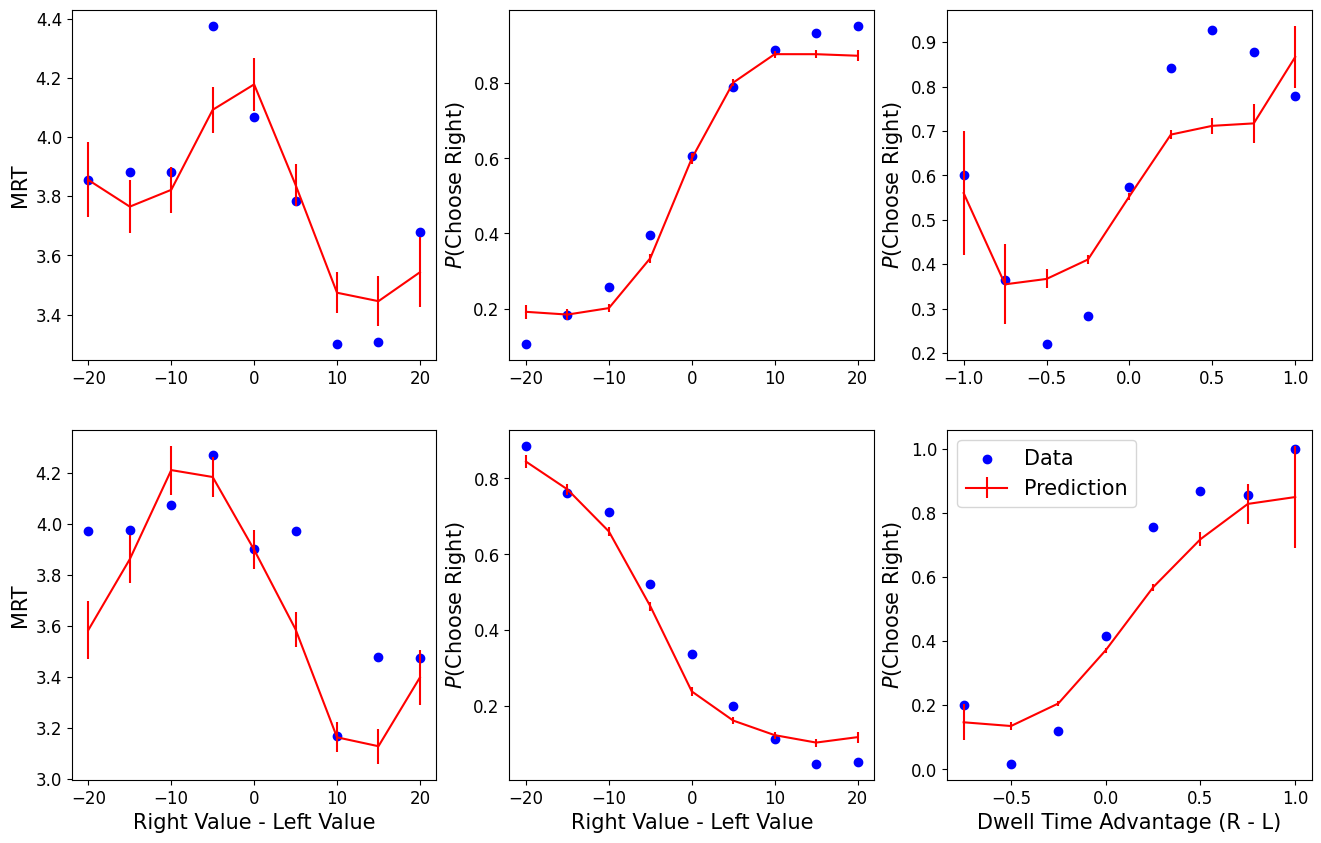

In [12]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.ylabel('MRT');

plt.subplot(232)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(233)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

###########
plt.subplot(234)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(235)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(236)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/sp2020_perceptual_complete_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

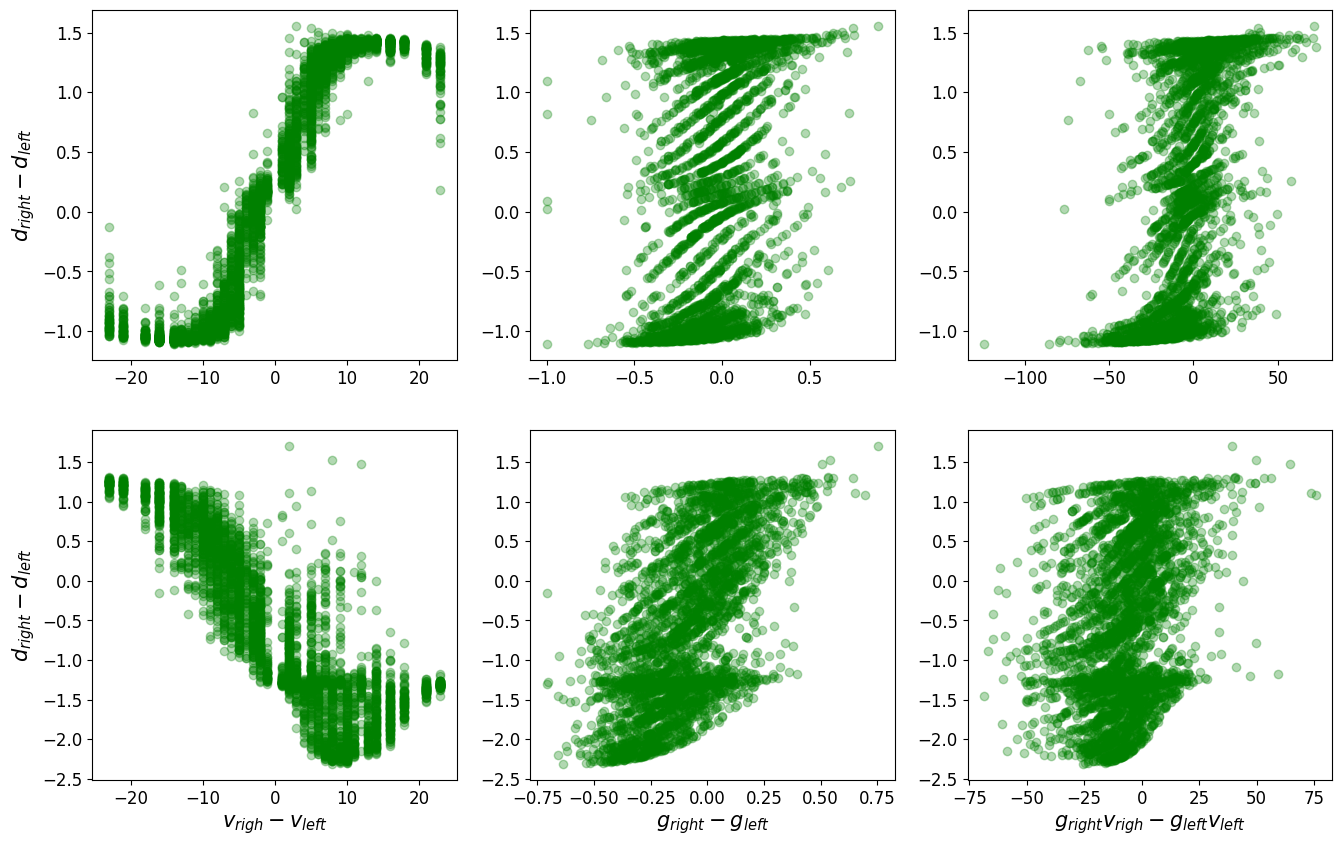

In [13]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_perceptual_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');